# Part 3 - Sentiment Analysis

In this notebook, we explore two models from the BERT family to perform sentiment analysis on reviews. 
- The first model has already been fine-tuned for this task and we can run inference on it
- We fine-tune the second model on our dataset to try to get better results

## Imports

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
import torch
from torch.nn.functional import softmax
from torch.utils.data import Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from datetime import datetime

from tqdm import tqdm
tqdm.pandas()  # Initialize tqdm with pandas
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# import helpers module
import helpers
import importlib
importlib.reload(helpers)

SEP = 100 * '-'

## Load dataset

In [2]:
# load dataset
data = helpers.load_pickled_dataset('pickle/data_processed.pkl')

helpers.print_random_product_sheet(data)

----------------------------------------------------------------------------------------------------
[name] Kindle Voyage E-reader, 6 High-Resolution Display (300 ppi) with Adaptive Built-in Light, PagePress Sensors, Wi-Fi - Includes Special Offers
----------------------------------------------------------------------------------------------------
[brand] Amazon
----------------------------------------------------------------------------------------------------
[categories] eBook Readers,Electronics Features,Walmart for Business,Tablets,See more Amazon Kindle Voyage (Wi-Fi),Electronics,Amazon Ereaders,Office Electronics,iPad & Tablets,Kindle E-readers,E-Readers & Accessories,All Tablets,See more Amazon Kindle Voyage 4GB, Wi-Fi  3G (Unlocked...,Amazon Book Reader,Computers & Tablets
----------------------------------------------------------------------------------------------------
[reviews.rating] 5.0
-------------------------------------------------------------------------------------

## Map sentiment based on rating
The review sentiment can take 3 values: negative, neutral or positive. Let's add a column and map the sentiment corresponding to the rating, for future inference, fine-tuning and comparison with the predictions. For that, we need to reduce the 5 star-labels to 3 sentiments (negative, neutral, positive), thus generating some imprecisions.

Since most people usually rate a product when they are happy or not, we can assume that the neutral sentiment is not very common and we will map it to 3 stars only, assuming that 1-2 starts is a negative comment and 4-5 stars a positive one.

In [3]:
# most people rate a product when they are happy or not, so we can assume that the neutral sentiment is not very common
review_mapping = {
    1: 'negative',
    2: 'negative',
    3: 'neutral',
    4: 'positive',
    5: 'positive'
}

data['reviews.sentiment'] = data['reviews.rating'].map(review_mapping)

print(data.info())
data['reviews.sentiment'].value_counts(normalize=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59046 entries, 0 to 59045
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   name                59046 non-null  object 
 1   brand               59046 non-null  object 
 2   categories          59046 non-null  object 
 3   reviews.rating      59046 non-null  float64
 4   reviews.numHelpful  59046 non-null  float64
 5   review              59046 non-null  object 
 6   reviews.sentiment   59046 non-null  object 
dtypes: float64(2), object(5)
memory usage: 3.2+ MB
None


reviews.sentiment
positive    0.916150
neutral     0.044525
negative    0.039325
Name: proportion, dtype: float64

Again, we notice how unbalanced our dataset is, with 91% of positive reviews.

## METHOD 1: Use a fine-tuned model
In this first approach, we use a HuggingFace model from the BERT family, that has already been fine-tuned for sentiment analysis. We can therefore run inference immediately, once our reviews are tokenized.

I did some research and decided to use [bert-base-multilingual-uncased-sentiment](https://huggingface.co/nlptown/bert-base-multilingual-uncased-sentiment?text=I+like+you.+I+love+you), wich is a BERT-family model fine-tuned on product reviews.

- This model has been fine-tuned on product reviews, which makes it more suitable for handling the nuances and specific vocabulary commonly found in reviews (e.g., product features, usability, satisfaction).

- Multilingual Support: Since it's multilingual, it can handle a wide range of languages if your Amazon reviews dataset includes non-English text. This makes it versatile if you encounter reviews in German, Spanish, or other languages.

- Performance: BERT models are known for their good performance on sentiment analysis tasks, and this particular model is specifically optimized for product review sentiment, likely making it more accurate in distinguishing subtle sentiment shifts in review data.

### Tokenize input and run inference on model

In [ ]:
# Load pre-trained model and tokenizer
model_name = "nlptown/bert-base-multilingual-uncased-sentiment"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)
model.to("cuda")

# Example function to predict sentiment for a single review
def predict_sentiment(review_text):
    inputs = tokenizer(review_text, return_tensors="pt", truncation=True, padding=True).to("cuda")
    outputs = model(**inputs)
    probabilities = torch.nn.functional.softmax(outputs.logits, dim=-1)
    sentiment = torch.argmax(probabilities).item()
    
    # we want to output 3 sentiments: negative, neutral, positive
    # for sentiments 1 and 3, we check side probabilities to decide
    if sentiment == 0:
        return 'negative'
    elif sentiment == 1:
        return 'negative' if probabilities[0][0] > probabilities[0][2] else 'neutral'
    elif sentiment == 2:
        return 'neutral'
    elif sentiment == 3:
        return 'positive' if probabilities[0][4] > probabilities[0][2] else 'neutral'
    else:
        return 'positive'


In [6]:
# Example usage
review = "This product is good."
print(f"Sentiment: {predict_sentiment(review)}")

review = "This is the worst product ever."
print(f"Sentiment: {predict_sentiment(review)}")

Sentiment: positive
Sentiment: negative


Running the model on the full dataset is very time consuming. Let's start with a subset of the dataset first.

In [ ]:
# create subset of the dataset
test_data = data.head(1000)

# predict on the dataset's reviews and store the result into a new column
test_data['predicted.sentiment'] = test_data['review'].progress_apply(predict_sentiment)

print(test_data.info())
test_data.head(10)


In [32]:
# let's compute an accuracy score to compare the predicted sentiment with the actual review
accuracy = (test_data['reviews.sentiment'] == test_data['predicted.sentiment']).mean()
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.76


This is not so bad. Let's run the accuracy on the whole dataset.

In [7]:
# predict on the dataset's reviews and store the result into a new column
data['predicted.sentiment'] = data['review'].progress_apply(predict_sentiment)

# print the accuracy score
accuracy = (test_data['reviews.sentiment'] == test_data['predicted.sentiment']).mean()
print(f"Accuracy: {accuracy:.2f}")


100%|██████████| 50174/50174 [06:06<00:00, 137.04it/s]

Accuracy: 0.76


The accuracy is sensibly the same.

## METHOD 2: Fine-Tune a Transformer on our dataset to increase accuracy

Our reviews are very specific to Amazon and amazon products. Let's fine tune a transformer model to do sentiment analysis on our dataset. This way it will be able to classify reviews without the star-rating.

### Model choice
As said, the star-rating system is not very accurate, due to the reduction of 5 star labels to 3 sentiments (negative, neutral, positive). So we should priorize a model that is fast (if we want it to run in real time for the demo) and don't need a high accuracy. Let's use [distilbert-base-uncased](https://huggingface.co/distilbert/distilbert-base-uncased) for that, which is a lightweight version of the BERT-family models.

## Load model

In [5]:
# Load DistilBERT tokenizer and model
model_name = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=3).to(device)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.weight', 'pre_classifier.weight', 'classifier.bias', 'pre_classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### Split the dataset

In [6]:
# Prepare features and labels
X = data['review'].to_list()
y = data['reviews.sentiment'].to_list()

# convert labels to integers, 0 for negative, 1 for neutral, 2 for positive
y = [0 if sentiment == 'negative' else 1 if sentiment == 'neutral' else 2 for sentiment in y]
print(set(y))  # check result

# Split data into train and validation sets (60-40 split)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

# Split validation set into validation and test sets (50-50 split)
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=0.5, stratify=y_val, random_state=42)

# print the number of samples in each set
print(len(X_train), len(y_train))
print(len(X_val), len(y_val))
print(len(X_test), len(y_test))


{0, 1, 2}
41332 41332
8857 8857
8857 8857


In [7]:
# Tokenize the data
train_encodings = tokenizer(X_train, truncation=True, padding="max_length", max_length=128)
val_encodings = tokenizer(X_val, truncation=True, padding="max_length", max_length=128)
test_encodings = tokenizer(X_test, truncation=True, padding="max_length", max_length=128)

print(train_encodings[0])

Encoding(num_tokens=128, attributes=[ids, type_ids, tokens, offsets, attention_mask, special_tokens_mask, overflowing])


In [8]:
# Create a Dataset Class
class EncodedDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        # Convert each tokenized item to tensor and add label as well
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item

    def __len__(self):
        return len(self.labels)

In [9]:
# Create the train and validation datasets
train_dataset = EncodedDataset(train_encodings, y_train)
val_dataset = EncodedDataset(val_encodings, y_val)
test_dataset = EncodedDataset(test_encodings, y_test)

In [10]:
# Define Training Arguments
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=5,
    weight_decay=0.01,
    logging_dir="./logs",
    report_to="none"
)

In [11]:
# Define metrics to track
def compute_metrics(pred):
    logits, labels = pred
    predictions = np.argmax(logits, axis=-1)
    
    # Calculate the metrics
    accuracy = accuracy_score(labels, predictions)
    precision = precision_score(labels, predictions, average='weighted')  # Weighted for class imbalance
    recall = recall_score(labels, predictions, average='weighted')
    f1 = f1_score(labels, predictions, average='weighted')
    
    return {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1": f1
    }

# Define Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics
)

# Fine-Tune the Model
trainer.train()

# Save model
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
model_path = f"models/distilbert_sa_{timestamp}"
model.save_pretrained(model_path)
print(f"Model saved to {model_path}")

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.116000,0.123554,0.963193,0.958464,0.963193,0.958689
2,0.098300,0.126838,0.971322,0.968978,0.971322,0.969247
3,0.051800,0.143393,0.970758,0.968768,0.970758,0.969436
4,0.040400,0.169555,0.971096,0.969134,0.971096,0.969701
5,0.020100,0.190264,0.969854,0.968276,0.969854,0.968895


Model saved to models/distilbert_sa_20241018_055429


### Plot validation loss

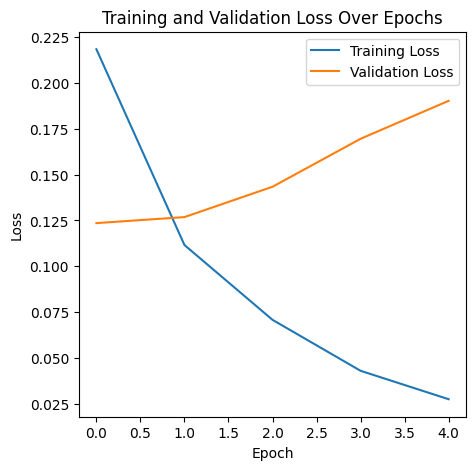

In [12]:
# Extract training and validation loss history
training_loss = []
validation_loss = []
for log in trainer.state.log_history:
    if "loss" in log.keys():  # Training loss per epoch
        training_loss.append(log["loss"])
    if "eval_loss" in log.keys():  # Validation loss per epoch
        validation_loss.append(log["eval_loss"])

# Plot the losses
plt.figure(figsize=(5, 5))
plt.plot(training_loss[::5], label="Training Loss")  # plot one every 5 points
plt.plot(validation_loss, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss Over Epochs")
plt.legend()
plt.show()

### Evaluate training

In [13]:
eval_results = trainer.evaluate()
for key, value in eval_results.items():
    print(f"{key}: {value}")


eval_loss: 0.19026371836662292
eval_accuracy: 0.9698543524895563
eval_precision: 0.9682758213128394
eval_recall: 0.9698543524895563
eval_f1: 0.9688952320052943
eval_runtime: 41.9153
eval_samples_per_second: 211.307
eval_steps_per_second: 13.217
epoch: 5.0


### Evaluate model on test set

In [14]:
# Run predictions on test set
test_results = trainer.predict(test_dataset=test_dataset)

# Extract and print accuracy from test results
for key, value in test_results.metrics.items():
    print(f"{key}: {value}")


test_loss: 0.15450145304203033
test_accuracy: 0.9753866997854804
test_precision: 0.9747242905960527
test_recall: 0.9753866997854804
test_f1: 0.9750092878391271
test_runtime: 43.2027
test_samples_per_second: 205.01
test_steps_per_second: 12.823


With a final accuracy of 97.5%, we can say that our fine-tuned model is doing a good job at assigning one of the 3 sentiments to reviews, some customer reviews being very short or ambiguous.

### Run test prediction

In [15]:
# load model
model_path = "models/distilbert_sa_20241017_211535"
model = AutoModelForSequenceClassification.from_pretrained(model_path, num_labels=3).to(device)
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

In [16]:
# set model in eval mode
model.eval()

# Define sentiment labels
sentiment_labels = ["Negative", "Neutral", "Positive"]

# Define function for prediction
def predict_sentiment(review_text):
    
    # Tokenize and predict on input text
    encodings = tokenizer(review_text, truncation=True, padding="max_length", max_length=128, return_tensors="pt").to(device)
    outputs = model(**encodings)
    probabilities = softmax(outputs.logits, dim=1)
    print(probabilities)
    predicted_class = torch.argmax(probabilities).item()  # Get the predicted class index
    return sentiment_labels[predicted_class]

predict_sentiment("This product is good, has a good battery but lately I had a lot of problems with it, it keeps restarting and frezes with no reason. I am not really satisfied.")

tensor([[0.0013, 0.9767, 0.0219]], device='cuda:0', grad_fn=<SoftmaxBackward0>)


'Neutral'

### Run batch prediction on reviews and store the results in dataset

In [17]:
# set model in eval mode
model.eval()

# Function to perform inference in batches
def predict_in_batches(model, texts, batch_size=32):
    predictions = []

    with torch.no_grad():  # Disable gradient tracking
        for i in range(0, len(texts), batch_size):
            batch_texts = texts[i : i + batch_size]
            # Tokenize the batch of texts
            encodings = tokenizer(batch_texts, truncation=True, padding="max_length", max_length=128, return_tensors="pt").to(device)
            
            # Run inference and get logits
            outputs = model(**encodings)
            batch_preds = torch.argmax(outputs.logits, dim=1)  # Get the predicted class
            predictions.extend(batch_preds.cpu().numpy())  # Move to CPU to avoid GPU memory overload

    return predictions

# Run the prediction function on your review column
data['reviews.ft'] = predict_in_batches(model, data['review'].tolist(), batch_size=32)


In [18]:
data['reviews.ft.sentiment'] = data['reviews.ft'].map({0: 'negative', 1: 'neutral', 2: 'positive'})

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59046 entries, 0 to 59045
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   name                  59046 non-null  object 
 1   brand                 59046 non-null  object 
 2   categories            59046 non-null  object 
 3   reviews.rating        59046 non-null  float64
 4   reviews.numHelpful    59046 non-null  float64
 5   review                59046 non-null  object 
 6   reviews.sentiment     59046 non-null  object 
 7   reviews.ft            59046 non-null  int64  
 8   reviews.ft.sentiment  59046 non-null  object 
dtypes: float64(2), int64(1), object(6)
memory usage: 4.1+ MB


### Compare predictions over real data

In [19]:
accuracy = (data['reviews.sentiment'] == data['reviews.ft.sentiment']).mean()
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.99


Obviously we are getting a much higher accuracy, considering that we run the model on the same data we used for training.

## Pickle Sentiment Analysis Results

In [20]:
data.to_pickle('pickle/data_sentiment_analysis.pkl')